<a href="https://colab.research.google.com/github/suzukimain/diffusers_in_Colab/blob/main/Image_generation_ver_Bete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#重要な注意点(Important Notes)：
 **・商用利用はご遠慮ください。**

 (Please do not use for commercial purposes.)

**・画像生成によって起こった問題について、私は一切責任を負いません。**

(I am not responsible for any problems caused by the image generation.)

>主に以下の内容が含まれます。

* モデルを使用して、違法または有害な出力またはコンテンツを意図的に作成または共有することはできません。

* モデル作成者は、利用者が生成した出力に対していかなる権利も主張せず、それらを利用者は自由に使用することができます。また、Licenseの規定に違反していない使用について、利用者は説明責任を負います。

* 重みを再配布し、モデルを商用またはサービスとして使用することができます。その場合、ライセンスに記載されているものと同じ制限を含めて、The CreativeML OpenRAIL Licenseのコピーをすべての利用者と共有する必要があることに注意してください。


上記の内容と、最下部に記載されている利用規約に同意できない方は、本画像生成ノートブックの使用はご遠慮ください。



>補足

下の方に画像のパスのコピーの方法を画像で説明しています。わからない方はご覧ください。

(The method for copying the path of an image is explained with images below. If you are unsure, please take a look.)

In [ ]:
#@title  #🔽実行する時このような三角のボタンを押してください{ run: "auto", display-mode: "form"}
#@markdown #Step1.セットアップ (Setup)

import locale #この2行は非常に重要
locale.getpreferredencoding = lambda: "UTF-8"

Google_driveに接続 = False  # @param {type:"boolean"}
#@markdown Googleドライブに保存したいときにチェックをしてください
from google.colab import drive
import google.colab.drive as drive
if Google_driveに接続:
  Gdrive="GoogleDrive: \033[32m接続成功\033[0m"
  try:
    drive.mount('/content/drive')
  except:
    Gdrive="GoogleDrive: \033[31m接続失敗\033[0m"
else:
  Gdrive="GoogleDrive: \033[33m接続なし\033[0m"
  if drive._os.path.ismount('/content/drive'):
     drive.flush_and_unmount()
     print("GoogleDriveの接続を解除しました")

import os


try:
  import torch
  import diffusers
  import transformers
  import accelerate
  import scipy
  import safetensors
  import ftfy
  import regex
  import tqdm
  import xformers
  import sentencepiece
  import pysbd
  import huggingface_hub
  import sacremoses

except:
  try:
    !pip install torch==2.0.1+cu118 diffusers==0.16.1 transformers==4.29.2 accelerate==0.19.0 scipy==1.10.1 safetensors==0.3.1 ftfy==6.1.1 regex==2022.10.31 tqdm==4.65.0 scipy==1.10.1 sentencepiece==0.1.99 pysbd==0.3.4 xformers huggingface_hub sacremoses -q
    !git clone https://github.com/huggingface/diffusers.git
    import torch
    import diffusers
    import transformers
    import accelerate
    import scipy
    import safetensors
    import ftfy
    import regex
    import tqdm
    import xformers
    import sentencepiece
    import pysbd
    import huggingface_hub
    import sacremoses

  except:
    raise RuntimeError("ランタイムをGPUに変更お願いします。またはページの再読み込みをお願いします")
try:
 import clip
except ModuleNotFoundError:
  !pip install git+https://github.com/openai/CLIP.git -q
  import clip
diffusers_path = "/content/diffusers"
if not os.path.exists(diffusers_path):
  !git clone https://github.com/huggingface/diffusers.git -q

import requests
import spacy
import codecs
import pickle
import torch
import random
import numpy as np
import transformers
import sentencepiece
import ipywidgets as widgets
from PIL import Image
from datetime import datetime
from transformers import pipeline
from transformers import GPT2Tokenizer, GPT2LMHeadModel, pipeline
from torch import Generator, autocast
from IPython.display import display, Markdown
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from diffusers import EulerDiscreteScheduler, StableDiffusionImg2ImgPipeline
from diffusers import DiffusionPipeline, AutoencoderKL, EulerAncestralDiscreteScheduler
from diffusers.models import AutoencoderKL
from PIL import Image, PngImagePlugin
from diffusers import DiffusionPipeline, EulerDiscreteScheduler, DPMSolverMultistepScheduler
from google.colab import drive
import google.colab.drive as drive
m_dir = '/content/モデルフォルダ'
if not os.path.exists(m_dir):
  os.makedirs(m_dir)
def model_paths(m_dir):
  file_name = os.listdir(m_dir)[0] # フォルダ内の最初のファイル名を取得
  model_path=os.path.join(m_dir)
  return model_path

from google.colab import drive
import google.colab.drive as drive
if Google_driveに接続:
  try:
    drive.mount('/content/drive')
  except:
    print("\033[31mGoogleDriveへの接続に失敗しました\033[0m")
else:
  if drive._os.path.ismount('/content/drive'):
     drive.flush_and_unmount()
     print("GoogleDriveの接続を解除しました")

if drive._os.path.ismount('/content/drive'):
  Connect_Gdrive="GoogleDrive: \033[32m接続成功\033[0m"

else:
  Connect_Gdrive="GoogleDrive: \033[33m接続なし\033[0m"

step1_finish=True

print(Connect_Gdrive)
print("\033[32mセットアップが完了しました。必要に応じて '/content/入力するモデルファイル'に使いたいモデルファイルを入れてください\033[0m")

In [ ]:
#@title  #Step2.モードの選択 (Mode Selection){ run: "auto", display-mode: "form"}


#"\033[31m先にStep.1を実行してください\033[0m"


# @markdown >使用するモデルの切り替え (model change)

model_select = "Counterfeit-V2.5(Anime)" #@param ["stable diffusion-v2.1(basic)", "waifu diffusion-v1.4(Anime)(better)","Anything-v3.0(Anime)","Anything-v4.5(Anime)","anything-midjourney-v-4-1(Anime)","ACertainThing(Anime)","anime-anything-promptgen-v2(Anime)","anime-kawai-diffusion(Anime)","AB4.5_AC0.2(Anime)","basil_mix(Anime)","chilled_remix(Anime)","Counterfeit-V2.5(Anime)","Counterfeit(Anime)","Double-Exposure-Diffusion(Anime)","EimisAnimeDiffusion_1.0v(Anime)","EimisAnimeDiffusion-v2.0(Anime)","loliDiffusion(Anime)","SukiyakiMix-v1.0(Anime)","openjourney(Anime)","7th_Layer(Anime)","Riga_Collection(Anime)","Realistic_Vision_V2.0(Reality)","Custom"]

#削除モデル(使えないもの)"epic-space-machine(space_ship)","spacemidj(space)","nasa_space_v2(space)"

#@markdown Customモードは "入力するモデルフォルダ" に１つのモデルファイルを入れてください

# @markdown >モードの切り替え (mode change)
mode_select = "Nomal(better)" #@param ["Nomal(better)","Quick"]

#@markdown * "Nomal" 品質と生成時間のバランス重視です

#@markdown * "Quick" 少し品質が低下する代わりに生成時間が大幅に短縮します


入力形式 = "text_only(better)" #@param ["text_only(better)", "image_and_text"]

# @markdown

#text_generate_model= "anime-anything-promptgen-v2" #@param ["MagicPrompt-Stable-Diffusion","anime-anything-promptgen-v2"]


# @markdown

# @markdown >フィルターを調整

# @markdown **注意事項 : 変更する時は注意して下さい**

Filter_off = False  # @param {type:"boolean"}

# @markdown 追記:人が映り込んだだけでフィルタリングされることがあったので追加しました


if "step1_finish" not in locals() or not step1_finish:
  raise NameError("\033[33m先にStep.1の実行をお願いします\033[0m")
else:
  pass



def print_text():
  if mode_select == "Nomal(better)":
     mode_text="mode: Nomal"
  else:
     mode_text="mode: Quick"
  return mode_text

def print_format():
  if 入力形式 == "text_only(better)":
    word_format="入力形式: text_only"
  else:
    word_format="入力形式: image_and_text"
  return word_format

mode_text=print_text()
word_format=print_format()


def result():
  if Filter_off == False:
     filter_level = "フィルターの強度:通常"
  else:
     filter_level = "\033[33mフィルターの強度:無効\033[0m"
  return filter_level

def safe():
  if Filter_off ==False:
    safety_checker = ""

  else:
    safety_checker = None
  return safety_checker


import requests
import spacy
import codecs
import pickle
import torch
import random
import numpy as np
import transformers
import sentencepiece
import ipywidgets as widgets
from diffusers import StableDiffusionPipeline
from huggingface_hub import hf_hub_download
from safetensors.torch import save_file
from PIL import Image
from datetime import datetime
from transformers import pipeline
from torch import Generator, autocast
from IPython.display import display, Markdown
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from diffusers import EulerDiscreteScheduler, StableDiffusionImg2ImgPipeline
from diffusers import DiffusionPipeline, AutoencoderKL, EulerAncestralDiscreteScheduler
from diffusers.models import AutoencoderKL

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 使用するモデルを設定
if model_select =="Custom":
   model_id="Custom"
   model_name="Custom"

elif model_select == "stable diffusion-v2.1(basic)":
   model_id = "stabilityai/stable-diffusion-2-1"
   model_name = "stable_diffusion-v2.1"
   g_scale ="7"
elif model_select == "waifu diffusion-v1.4(Anime)(better)":
   model_id = "hakurei/waifu-diffusion"
   model_name = "waifu_diffusion-v1.4"
   g_scale ="7"

elif model_select == "Anything-v3.0(Anime)":
   model_id = "Linaqruf/anything-v3.0"
   model_name = "Anything-v3.0"
#   g_scale =

elif model_select == "anything-midjourney-v-4-1(Anime)":
  model_id = "Joeythemonster/anything-midjourney-v-4-1"
  model_name ="anything-midjourney-v-4-1"
   # g_scale =

elif model_select == "Anything-v4.5(Anime)":
   model_id = "shibal1/anything-v4.5-clone"
   model_name = "Anything-v4.5"
 #  g_scale =shibal1/anything-v4.5-clone  Airic/Anything-V4.5

#elif model_select == "anything-v5.0(Anime)":
#   model_id = "ckpt/anything-v5.0"
#   model_name="anything-v5.0"

elif model_select == "loliDiffusion(Anime)":
   model_id = "JosefJilek/loliDiffusion"
   model_name = "loliDiffusion"

elif model_select == "AB4.5_AC0.2(Anime)":
   model_id = "aioe/AB4.5_AC0.2"
   model_name = "AB4.5_AC0.2"

elif model_select == "basil_mix(Anime)":
   model_id = "nuigurumi/basil_mix"
   model_name = "basil_mix"



elif model_select == "Double-Exposure-Diffusion(Anime)":
   model_id = "joachimsallstrom/Double-Exposure-Diffusion"
   model_name = "Double-Exposure-Diffusion"

elif model_select == "openjourney(Anime)":
   model_id = "prompthero/openjourney"
   model_name= "prompthero/openjourney"


elif model_select == "ACertainThing(Anime)":
   model_id ="JosephusCheung/ACertainThing"
   model_name="JosephusCheung/ACertainThing"
 #  g_scale=

#elif model_select == "Counterfeit-V2.0(Anime)":
#   model_id = "gsdf/Counterfeit-V2.0"
#   model_name= "Counterfeit-V2.0"
#   g_scale =

elif model_select =="Counterfeit-V2.5(Anime)":
   model_id = "gsdf/Counterfeit-V2.5"
   model_name ="Counterfeit-V2.5"

elif model_select == "SukiyakiMix-v1.0(Anime)":
  model_id = "Vsukiyaki/SukiyakiMix-v1.0"
  model_name = "SukiyakiMix-v1.0"
#  g_scale =

elif model_select == "7th_Layer(Anime)":
   model_id = "syaimu/7th_test"
   model_name = "7th_Layer"
 #  g_scale =

elif model_select == "EimisAnimeDiffusion-v2.0(Anime)":
   model_id = "eimiss/EimisAnimeDiffusion_2.0v"
   model_name = "EimisAnimeDiffusion-v2.0"
 #  g_scale =

elif model_select == "EimisAnimeDiffusion_1.0v(Anime)":
   model_id = "eimiss/EimisAnimeDiffusion_1.0v"
   model_name = "EimisAnimeDiffusion_1.0v"

elif model_select=="Riga_Collection(Anime)":
   mdoel_id ="natsusakiyomi/Riga_Collection"
   model_name="Riga_Collection"
  # g_scale =

# モードの切り替え (mode change)
elif model_select =="anime-kawai-diffusion(Anime)":
  model_id="Ojimi/anime-kawai-diffusion"
  model_name="anime-kawai-diffusion"
 # g_scale =

elif model_select == "anything-midjourney-v-4-1(Anime)":
  model_id = "Joeythemonster/anything-midjourney-v-4-1"
  model_name ="anything-midjourney-v-4-1"
   # g_scale =

#elif model_select=="nasa_space_v2(space)":
#  model_id="sd-dreambooth-library/nasa-space-v2-768"
#  model_name="nasa-space-v2-768"

#elif model_select=="epic-space-machine(space_ship)":
#  model_id="rabidgremlin/sd-db-epic-space-machine"
#  model_name="sd-db-epic-space-machine"

#elif model_select=="spacemidj(space)":
#  model_id="Falah/spacemidj"
#  model_name="spacemidj"

elif model_select=="Realistic_Vision_V2.0(Reality)":
  model_id="SG161222/Realistic_Vision_V2.0"
  model_name="Realistic_Vision_V2.0"


elif model_select=="chilled_remix(Anime)":
  model_id="sazyou-roukaku/chilled_remix"
  model_name="sazyou-roukaku/chilled_remix"


#if text_generate_model == "MagicPrompt-Stable-Diffusion":
#  text_model_name = "Gustavosta/MagicPrompt-Stable-Diffusion"
#elif text_generate_model == "anime-anything-promptgen-v2":
#   text_model_name = "FredZhang7/anime-anything-promptgen-v2"



#vae_name="stabilityai/sd-vae-ft-mse"
#vae = AutoencoderKL.from_pretrained(vae_name)

#diffuser_kwargs = {
#   "negative_prompt": "worst quality, low quality, medium quality, deleted, lowres, comic, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, jpeg artifacts, signature, watermark, username, blurry",
#   "seed": 72566,
#   "temperature": 0.8,
#   "truncation": 0.8,
#   "diffusion_steps": 500
#}


# Load the base pipeline.
#base_model_id = "CompVis/stable-diffusion-v1-4"
#pipeline = StableDiffusionPipeline.from_pretrained(base_model_id)

# Get the LoRA parameters in PyTorch.
#torch_path = hf_hub_download(
#    "sayakpaul/sd-model-finetuned-lora-t4", "pytorch_lora_weights.bin"
#)
#pt_state_dict = torch.load(torch_path, map_location=torch.device("cpu"))

# Convert to safetensors and serialize.
#state_dict_safetensors = "pytorch_lora_weights.safetensors"
#save_file(state_dict, state_dict_safetensors, metadata={"format": "pt"})

# Load the safetensors LoRA params into `pipeline.unet`.
#pipeline.unet.load_attn_procs(".")

#入れられないけど  Deyo/SEmix


def pipe_setup():
  if not model_id=="Custom":
    #vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
    if 入力形式 == "text_only(better)":
      if Filter_off==True:
        # StableDiffusion(メインのモジュール)パイプライン設定
        # もしも何かあったら"torch_dtype=torch.float16"をつける
        pipe = StableDiffusionPipeline.from_pretrained(
            model_id, torch_dtype=torch.float16 if mode_select == "Quick" else torch.float32,
            safety_checker= None,
            use_safetensors=True,
            clip_model=lambda x: model.encode_image(x).float(),
            #vae=vae
        )
        pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

      else:
        pipe = StableDiffusionPipeline.from_pretrained(
            model_id, torch_dtype=torch.float16 if mode_select == "Quick" else torch.float32,
            clip_model=lambda x: model.encode_image(x).float(),
            use_safetensors=True,
            #vae=vae
        )
        pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    else:
      if Filter_off==True:
        #StableDiffusionパイプライン設定
        scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
      else:
        scheduler = EulerDiscreteScheduler.from_pretrained(model_id,safety_checker= None, subfolder="scheduler")
  else:
    try:
      model_path=model_paths(m_dir,file_name)
      pipe = StableDiffusionPipeline.from_ckpt(model_path)
    except:
      raise FileNotFoundError("'入力するモデルファイル'からモデルを読み込めませんでした。モデルファイルが存在しないか対応していない形式の可能性があります")
  pipe = pipe.to(device)
  return pipe


#def ima3ima(modl_id):
 # model_T="stable_diffusion_txt2img"+model_id
  #return model_T
#ima3ima(model_id)
# txt2img モードで Pipeline オブジェクトを作成
#model_T = StableDiffusionPipeline.from_pretrained(model_id)

# generate text using fine-tuned model
#nlp = pipeline('text-generation', model=text_model_name)

pipe=pipe_setup()
#pipe.load_textual_inversion(
#    "sayakpaul/EasyNegative-test", weight_name="EasyNegative.safetensors", token="EasyNegative"
#)
#pipe.load_textual_inversion(
#"nolanaatama/embeddings", weight_name="EasyNegativeV2.safetensors", token="EasyNegative"
#)
filter_level=result()

print(mode_text)
print(word_format)
print(filter_level)

#\033[31mが赤、\033[33mが黄色、\033[34mが青、\033[32mが緑、\033[0mが白
# "\033[32m" は緑色に変更するための"ANSI Escape Code"であり、"\033[0m"はデフォルトの文字色に戻すためのコードです。
print("\033[32m画像生成の準備が出来たので、手順3に移ってください。\033[0m")
print("\033[32m(Now that the image generation is ready, please proceed to step 3.)\033[0m")

In [ ]:
#@title  #Step3.画像の生成  (iamge generation){display-mode: "form"}

#@markdown #自動生成

自動で条件を決めて生成 = True #@param {type:"boolean"}

#@markdown **操作がよくわからない方はチェックをつけて下さい。自動で生成します**

#@markdown >この機能の詳細
#@markdown  * 詳細設定を推奨の値に設定
#@markdown  * プロンプトが入力されていない場合、初期値として "1girl" / "1woman" のいずれかを入力

#@markdown  >次の機能をオンにします
#@markdown   * 画面に表示
#@markdown   * 画像の質を上げるプロントを追加する
#@markdown   * プロンプトアシストを使う ( MagicPrompt )
#@markdown   * 推奨するネガティブプロントを使用
#@markdown   * 条件をメタデーターとして追加する


#@markdown

#@markdown -----

# @markdown >生成したい枚数を入力してください　/ Please enter the number of images you want to generate here.
生成する枚数 = 1 #@param {type:"slider", min:1, max:100, step:1}
枚数制限なし = False #@param {type:"boolean"}
#if 生成する枚数 <= 0 or isinstance(生成する枚数, float):
  #  print("\033[31m警告:無効な数字が入力された為デフォルトの1枚に設定しました\033[0m")
  #  生成する枚数 = 1
#if 生成する枚数 is None:
 #   print("\033[31m警告:無効な形式な為デフォルトの1枚に設定しました\033[0m")
#    生成する枚数 = 1

# @markdown  デフォルトでは1回につき1枚生成します。(By default, one image will be generated per run.)

# @markdown ------

# @markdown  >生成する画像の条件を**英語で**入力してください　(Please input the conditions for generating images in **English**.)

Prompt = "" #@param {type:"string"}
画像の質を上げるプロントを追加する = True #@param {type:"boolean"}
#プロンプトアシストを使う = True #@param {type:"boolean"}
日本語入力 = False #@param {type:"boolean"}

# @markdown ------
# @markdown >プロンプトアシスタントの選択
text_generate_model= "anime-anything-promptgen-v2" #@param ["None","MagicPrompt-Stable-Diffusion","anime-anything-promptgen-v2"]

# @markdown アニメ調の画像に適したアシスタントは " anime-anything-promptgen-v2 "

# @markdown 多目的のアシスタントは " MagicPrompt-Stable-Diffusion "

# @markdown 使用しない場合は " None " の選択をお願いします


# @markdown >**プロンプトの例**
# @markdown * "cute, cat"
# @markdown * "Earth, space, high resolution"
# @markdown * "Please draw a beautiful Mount Fuji with the sun rising from the summit."
# @markdown * "smail,1girl, white hair, medium hair, cat ears, looking at viewer, :3, cute,white_dress"

# @markdown ------

# @markdown >画像を入力として送リます。

入力する画像 = "" #@param {type:"string"}
# @markdown 入力形式を "image_and_text" とした場合のみに使えます


# @markdown ------

#@markdown #詳細設定

seed = None #@param {type:"number"}
guidance_scale = 10 #@param {type:"slider", min:5, max:30, step:1}
温度 = 0.7 #@param {type:"slider", min:0, max:1, step:0.1}
#top_k = 17 #@param {type:"slider", min:1, max:40, step:1}
#top_p = 0 #@param {type:"slider", min:0, max:1, step:0.01}
雰囲気 = 0.9 #@param {type:"slider", min:0.1, max:1, step:0.1}
拡散ステップ = 50  # @param {type:"number"}
#safe_level = "safe" #@param ["safe", "Questionable", "Explicit"]
縦の長さ = "512" #@param ["480","512","600", "768","800", "1080","1152", "1440", "1920", "3840", "7680"]
横の長さ = "512" #@param ["480","512","600", "768","800", "1080","1152", "1440", "1920", "3840", "7680"]
height = int(縦の長さ)
width = int(横の長さ)

#@markdown >用語の説明

#@markdown * seed ("0"以上) / seed値を指定します。指定しない場合はランダムです。

#@markdown * guidance_scale (5≦30 推奨"8") / どのくらい細かく描くかを指定します。

#@markdown * 温度(0.1≦1.0 推奨"0.8") / どのくらい条件に合わせるかを指定します。

#@markdown * 拡散ステップ(1≦1000 推奨"50") / 何回計算をするかです。回数を減らすほど生成速度が速くなります

#@markdown * 解像度 ( 推奨"512" ) / 画像の大きさを指定します。あまり生成速度に影響はありません

# @markdown ------

# @markdown >必要であればネガティブプロンプトを入力してください。人物を生成するときにおすすめです

# @markdown よくわからない方ボタンを押してください。おすすめのネガティブプロントを使います

## @markdown (If necessary, please enter a negative prompt. It is recommended for generating characters.)

N_prompt = ""  # @param {type:"string"}
推奨するネガティブプロントを使用 = True #@param {type:"boolean"}
# @markdown ネガティブプロンプトとは、**ネガティブな要素を除く**ものです。

## @markdown (Negative prompts are used to exclude negative elements from an image. For example, you can use a negative prompt to exclude low quality images or images that are not beautiful.)

# @markdown ------

#@markdown >保存する先を指定します

## @markdown (If you would like to specify a location to save the generated image, please enter the path.)

保存する先のパス = ""  # @param {type:"string"}
#@markdown デフォルトでは "/content/生成した画像" に保存されます。なければ作るようになっています。

##@markdown (If no path is specified, the images will be saved to "/content/生成した画像". The directory will be created if it doesn't exist.)

# @markdown

# @markdown **補足説明**

# @markdown "/content/生成した画像"は左のタスクバーにあるファイルのマークを押すと"生成した画像"のフォルダを見れます
# @markdown

## @markdown (P.S.You can see the images generated at '/content/生成した画像' by clicking the file icon in the left taskbar.)

# @markdown ------

# @markdown >生成した画像を画面に表示します

画面に表示 = True  # @param {type:"boolean"}
プロンプトを表示 = True  # @param {type:"boolean"}
条件をメタデーターとして追加する = True  # @param {type:"boolean"}


if "pipe" not in locals() or not pipe:
  raise NameError("\033[33mパイプラインが見つかりませんでした。Step.2を再度実行してください\033[0m")




if 入力形式=="image_and_text":
  try:
    init_image = Image.open(入力する画像)
    init_image = init_image.convert("RGB")
    init_image = init_image.resize((768, 512))
  except:
    raise FileNotFoundError('入力する画像が見つかりませんでした。画像を入力しない場合は、Step.1の入力形式を"text_only"に変更お願いします')

if text_generate_model == "None":
  text_model_name=""
elif text_generate_model == "MagicPrompt-Stable-Diffusion" or 自動で条件を決めて生成:
  text_model_name = "Gustavosta/MagicPrompt-Stable-Diffusion"
  if "MagicPrompt" not in locals() or not MagicPrompt:
    MagicPrompt = pipeline('text-generation', model=text_model_name)
elif text_generate_model == "anime-anything-promptgen-v2":
  text_model_name = "FredZhang7/anime-anything-promptgen-v2"
  if "AnythingPrompt" not in locals() or not AnythingPrompt:
    AnythingPrompt = pipeline('text-generation', model=text_model_name)

def word_preprocessing(Prompt):
  if not Prompt=="":
    if 日本語入力:
      texts = Prompt
      encoded_text = codecs.encode(texts, 'utf-8')
      decoded_text = codecs.decode(encoded_text, 'utf-8')
      pos_tagger = spacy.load('en_core_web_sm')
      fugu_translator = pipeline('translation', model='staka/fugumt-ja-en')
      translation = fugu_translator(decoded_text, src_lang="ja", tgt_lang="en")[0]["translation_text"]
      Prompt_2 = translation #After_Prompt
    else:
      Prompt_2 = Prompt
  else:
    add_word=random.choice(["1girl", "1woman"])
    Prompt_2=add_word
    print(f"プロンプトが未入力の為'{add_word}'を入力しました")
  return Prompt_2

def add_prompt(Prompt_2):
  if 画像の質を上げるプロントを追加する or 自動で条件を決めて生成 :
    追加 = "((((masterpiece)))), (((best quality))), high quality, "
  else:
    追加 = ""
  Prompt_3=追加+Prompt_2
  return Prompt_3

def easy_prompt(Prompt_3,text_model_name):
  if text_generate_model == "None":
    Prompt_4 = Prompt_3
  #elif プロンプトアシストを使う or 自動で条件を決めて生成:
  elif text_generate_model == "MagicPrompt-Stable-Diffusion" or 自動で条件を決めて生成:
    #outs = nlp(Prompt_3, max_length=73, num_return_sequences=1, do_sample=True, repetition_penalty=1.2, temperature=0.7, top_k=4, early_stopping=True)
    try:
      Prompt_4 = MagicPrompt(Prompt_3, max_length=73)[0]["generated_text"]
    except:
      MagicPrompt = pipeline('text-generation', model=text_model_name)
      Prompt_4 = MagicPrompt(Prompt_3, max_length=73)[0]["generated_text"]
  elif text_generate_model == "anime-anything-promptgen-v2":
    try:
      Prompt_4 = AnythingPrompt(Prompt_3, max_length=73)[0]["generated_text"]
    except:
      AnythingPrompt = pipeline('text-generation', model=text_model_name)
      Prompt_4 = AnythingPrompt(Prompt_3, max_length=73)[0]["generated_text"]
  else:
    Prompt_4 = Prompt_3
  return Prompt_4



def main_task():
  Prompt_2=word_preprocessing(Prompt)
  Prompt_3=add_prompt(Prompt_2)
  Prompt_4=easy_prompt(Prompt_3,text_model_name)
  prompt=Prompt_4
  return prompt

prompt = main_task()

if not Google_driveに接続:
  if "/content/drive/MyDrive" in 保存する先のパス:
    print("\033[31mGoogleドライブに接続されていないためデフォルトのパスに保存しました\033[0m")



if seed is None:
   seed = random.randint(1,1000000)



if 推奨するネガティブプロントを使用 or 自動で条件を決めて生成 :
  おすすめのネガティブプロント = ",((((worst quality)))), ((((low quality)))), blurred, medium quality, purple hair, deleted, lowres, comic, bad anatomy, (((bad hands))), low resolution, blurry, absurdres,pixelated, sketchy, nonsensical anatomy, unrealistic pose, mosaic, unclear details, distorted colors, unrealistic proportions, poor quality, fuzzy, out of focus, hazy, grainy, text, error, missing fingers, extra digit, fewer digits, cropped, jpeg artifacts, signature, watermark, username, standard quality, bad feet_hand_finger_leg_eye, bad, text font ui, bad shadow, poorly drawn, black-white, ugly, duplicate, mutation, mutilated, malformed mutated, malformed, The background is incoherent, simple background, low-quality background, low background, bad body, long body, broken limb, anatomical nonsense, extra limbs, missing limb, incorrect limb, multiple heads, twisted head, poorly drawn face, head_wings, More than two cows, missing head, 1 unit with multiple heads, heads together, abnormal eye proportion, unclear eyes, bad eyes, fused eyes, poorly drawn eyes, bad mouth, poorly drawn mouth, bad tongue, too long tongue, bad ears, poorly drawn ears, extra ears, heavy ears, long neck, too thick neck, bad neck, abnormally large breasts, extra_breasts, fused breasts, bad breasts, missing arms, disappearing arms, extra arms, three arms, mutated hands and fingers, black hands, fused hand, missing fingers, extra digits, huge thighs, disappearing thigh, missing thighs, extra thighs, bad feet, bad legs, huge calf, disappearing legs, bad gloves, fused gloves, beard, artist name, text watermark, unnatural, obviously wrong, distorted face, floating hair, floating body parts, severed body parts, incorrect leg position, deformed, fused body and hands, disregard of physics, distorted shape, doll-like object not present in the image, body fusion, abnormal fingers, fingers resembling fish fins, dot eyes, unclear background, mosaic, body bending, incorrect leg-to-torso ratio, excessively large breasts, more than three limbs (hands/legs), unsettling appearance, eyes filled with solid color, lack of lower body, splitting, creepy doll-like appearance, distorted eyes, lines on the skin, legs bending in unnatural directions, abnormal finger count, missing arms, floating hands, lack of nose or mouth, hands emerging from impossible places, incorrect body part ratios, bad, longbody, lowres, bad anatomy, bad hands, missing fingers, fat, big boobs, pubic hair, Distorted eye contour, Missing part from the ankles onward, extra digit, fewer digits, split wings, Vampire wings floating in the air, bad wing, cropped"
else:
  おすすめのネガティブプロント =""


NOT_prompt = N_prompt + おすすめのネガティブプロント

negative_prompt2=("((((nsfw))))"+ NOT_prompt)


#new_diffuser_kwargs = {
#   "negative_prompt":negative_prompt2,
#   "seed": seed値,
#   "temperature": 温度,
#   "truncation": 雰囲気,
#   "diffusion_steps": 拡散ステップ
#   }
if 枚数制限なし:
  生成する枚数=10000
  st="∞"
else:
  st=生成する枚数
#returnを使うとfor文が機能しないからdef関数は使えない
GE_images_dir="/tmp/generated_images"
if not os.path.exists(GE_images_dir):
  os.makedirs(GE_images_dir)


if 保存する先のパス:
  if not Google_driveに接続:
    if "/content/drive/MyDrive" in 保存する先のパス:
      image_save_path="/content/生成した画像"
      print("\033[31mGoogleドライブに接続されていないためデフォルトのパスに保存しました\033[0m")
    else:
      image_save_path=保存する先のパス
  else:
    image_save_path=保存する先のパス
else:
  image_save_path="/content/生成した画像"
if not os.path.exists(image_save_path):
      os.makedirs(image_save_path)

generator = torch.Generator(device).manual_seed(seed)
sd_step=拡散ステップ
def generate_images(st,prompt,generator,image_save_path,sd_step,seed):
    #generator.manual_seed(seed)
    #diffuser_kwargs.update(new_diffuser_kwargs)
    i=1
    for i in range(生成する枚数):
      j=i+1
      now = datetime.now()
      date_str = now.strftime("%Y-%m-%d_UTC-%H:%M:%S")
      filenames = f"seed({seed})_model({model_name})_ガイダンス({guidance_scale})温度({温度})_雰囲気({雰囲気})_{date_str}.png"
      path = os.path.join(image_save_path, filenames)
      GE_images_path = os.path.join(GE_images_dir, filenames)
      if 入力形式 == "image_and_text":
        with autocast("cuda"):
          result = pipe(prompt, image=init_image, negative_prompt=negative_prompt2, num_inference_steps=sd_step,height=height,width=width,guidance_scale=guidance_scale,generator=generator)
          make_image = result.images[0]  # 生成された画像はリストの最初の要素に格納されている
      else:
        with autocast("cuda"):
          result = pipe(prompt, negative_prompt=negative_prompt2, guidance_scale=guidance_scale, num_inference_steps=sd_step,height=height,width=width,generator=generator)
          make_image = result.images[0]
      info = make_image.info
      if 条件をメタデーターとして追加する or 自動で条件を決めて生成:
        metadata = {
            "Seed": seed,
            "model": model_name,
            "G_scale":guidance_scale,
            "D_step":sd_step,
            "Prompt": Prompt,
            "n_prompt":negative_prompt2
           }
        pnginfo = PngImagePlugin.PngInfo()
        for key, value in metadata.items():
            pnginfo.add_text(key, str(value))
        make_image.save(path, pnginfo=pnginfo)
      else:
        make_image.save(path)
      print("\033[34m画像生成が完了しました(",j,"/",st,")")
      print("保存先のパス:(\033[32m content/生成した画像\033[34m)")
      print("ファイルの名前:(\033[32m"+ filenames +"\033[34m)")
      print("上記のようになります。ご確認ください\033[0m")
      if 画面に表示 or 自動で条件を決めて生成:
          make_image.show()
      if プロンプトを表示:
          print('\033[92mプロンプト:  ' + prompt + '\033[0m\n')
generate_images(st,prompt,generator,image_save_path,sd_step,seed)

In [ ]:
#@title 画像のメタデーターを見る  {display-mode: "form"}
from PIL import Image, PngImagePlugin
import os
image_metadata_path = "" #@param {type:"string"}
if not os.path.exists(image_metadata_path):
  raise FileNotFoundError("ファイルが見つかりませんでした")
try:
  output_info = Image.open(image_metadata_path).info
except:
  raise FileNotFoundError("画像を読み込めませんでした")

try:
  print("seed: "+output_info["Seed"]+"\n")
  print("diffusion_step: "+output_info["D_step"]+"\n")
  print("guidance_scale: "+output_info["G_scale"]+"\n")
  print("model_name : "+output_info["model"]+"\n")
  print("prompt: \033[92m"+output_info["Prompt"]+"\033[0m\n")
except:
  print("\033[31mメタデーターが見つかりませんでした\033[0m")

In [ ]:
#@title  {display-mode: "form"}
#@markdown >zip形式にしてダウンロードします。
from google.colab import files
import shutil
import os

try:
  z=z+1
except:
  z=1
base_save_dir="/tmp/generated_images"
zip_name=f"Generated_images-No.{z}"
zip_save_dir=os.path.join("/content",zip_name)
zippath=zip_save_dir+".zip"
try:
  shutil.make_archive(zip_save_dir, "zip", base_save_dir)
  files.download(zippath)
  print("\033[32mzipファイルへ圧縮が正常に完了しました")
  print(f'zipファイル名前は\033[34m"{zip_name}"\033[32mですご確認ください\033[0m')
except:
  print("\033[31m生成した画像が見つかりませんでした\033[0m")

In [ ]:
#@title  {display-mode: "form"}
ランタイムを一時的に切断する = False #@param {type: 'boolean'}
#@markdown 作業を中断するときなどにチェックをつけて実行してください /Please check and execute when interrupting the task.
if ランタイムを一時的に切断する == True:
    from google.colab import runtime
    runtime.unassign()
else:
  print('ランタイムの切断をキャンセルしました')

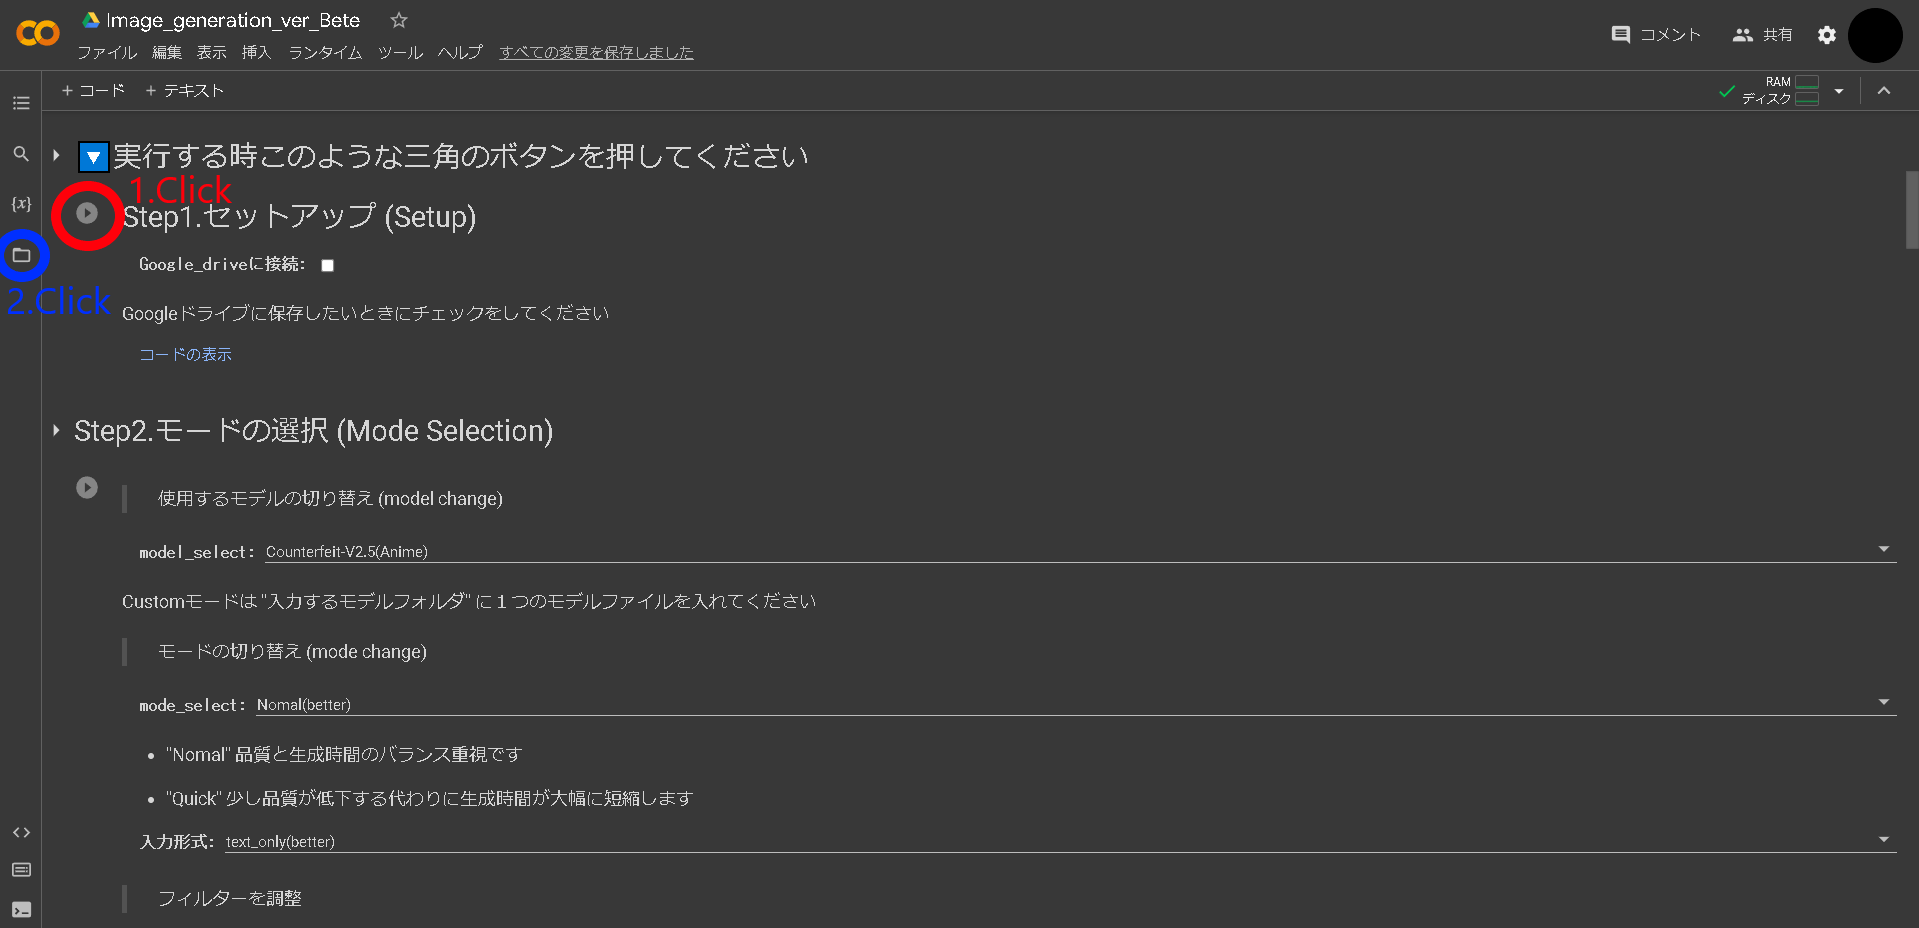

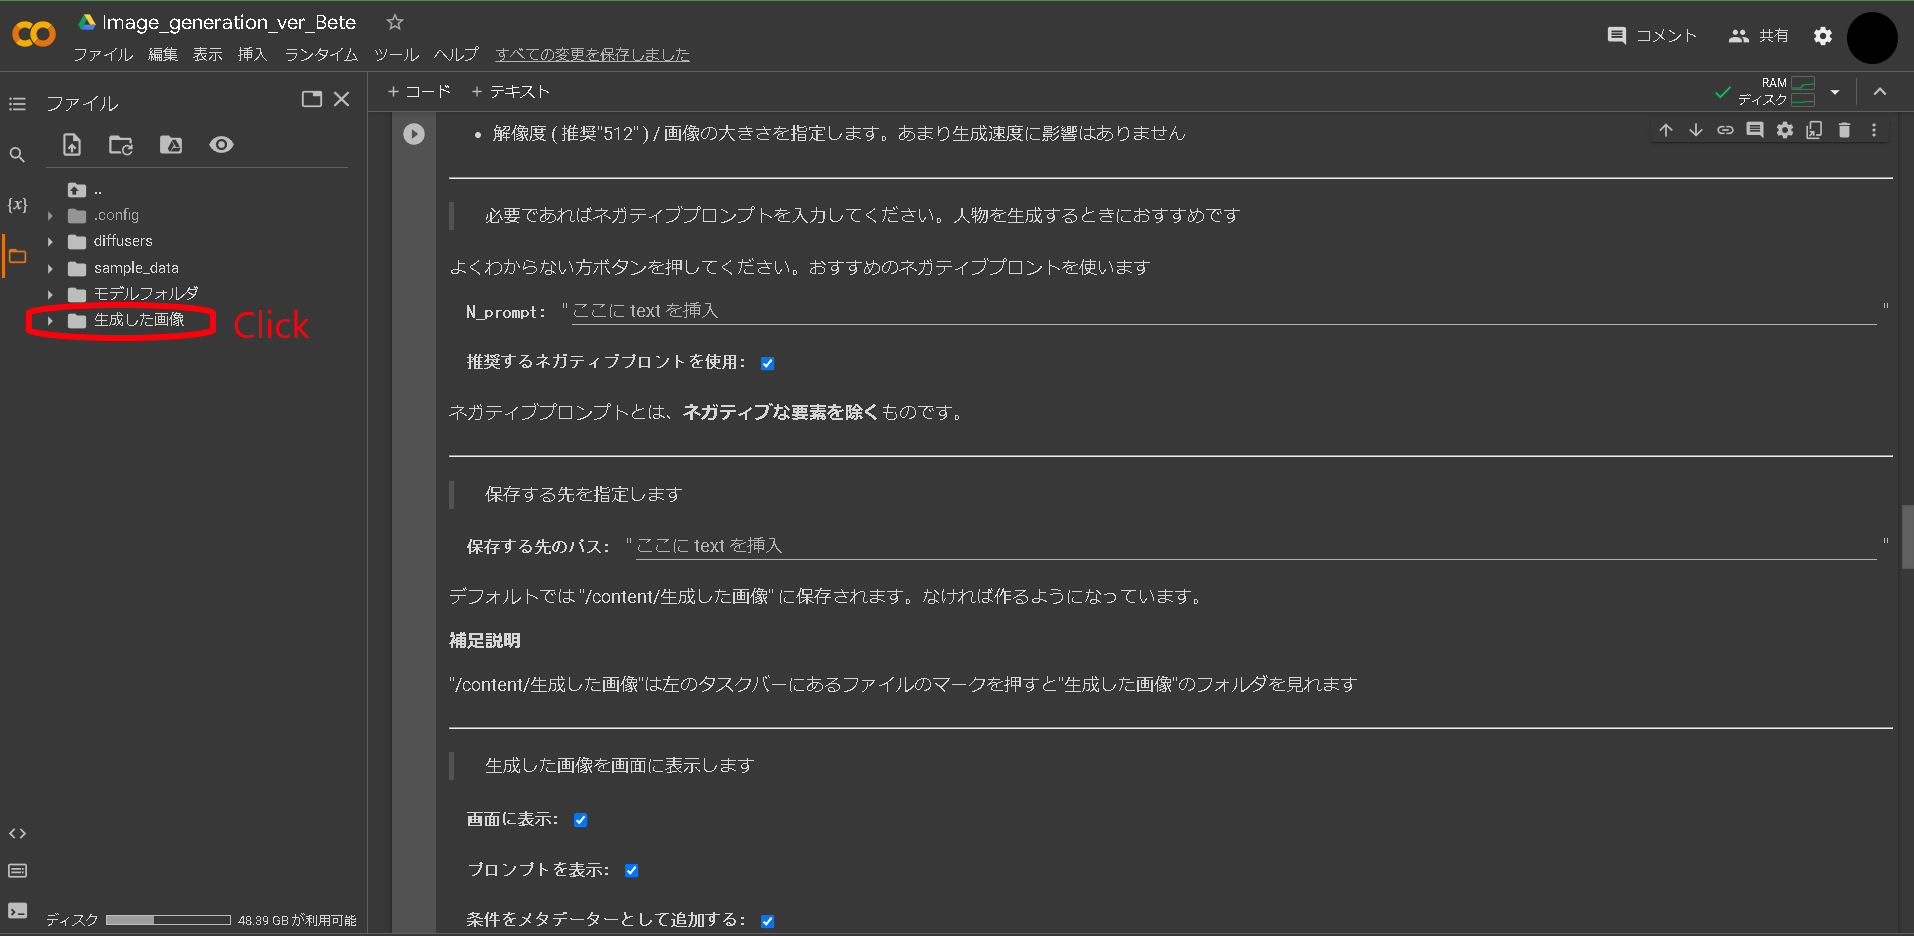

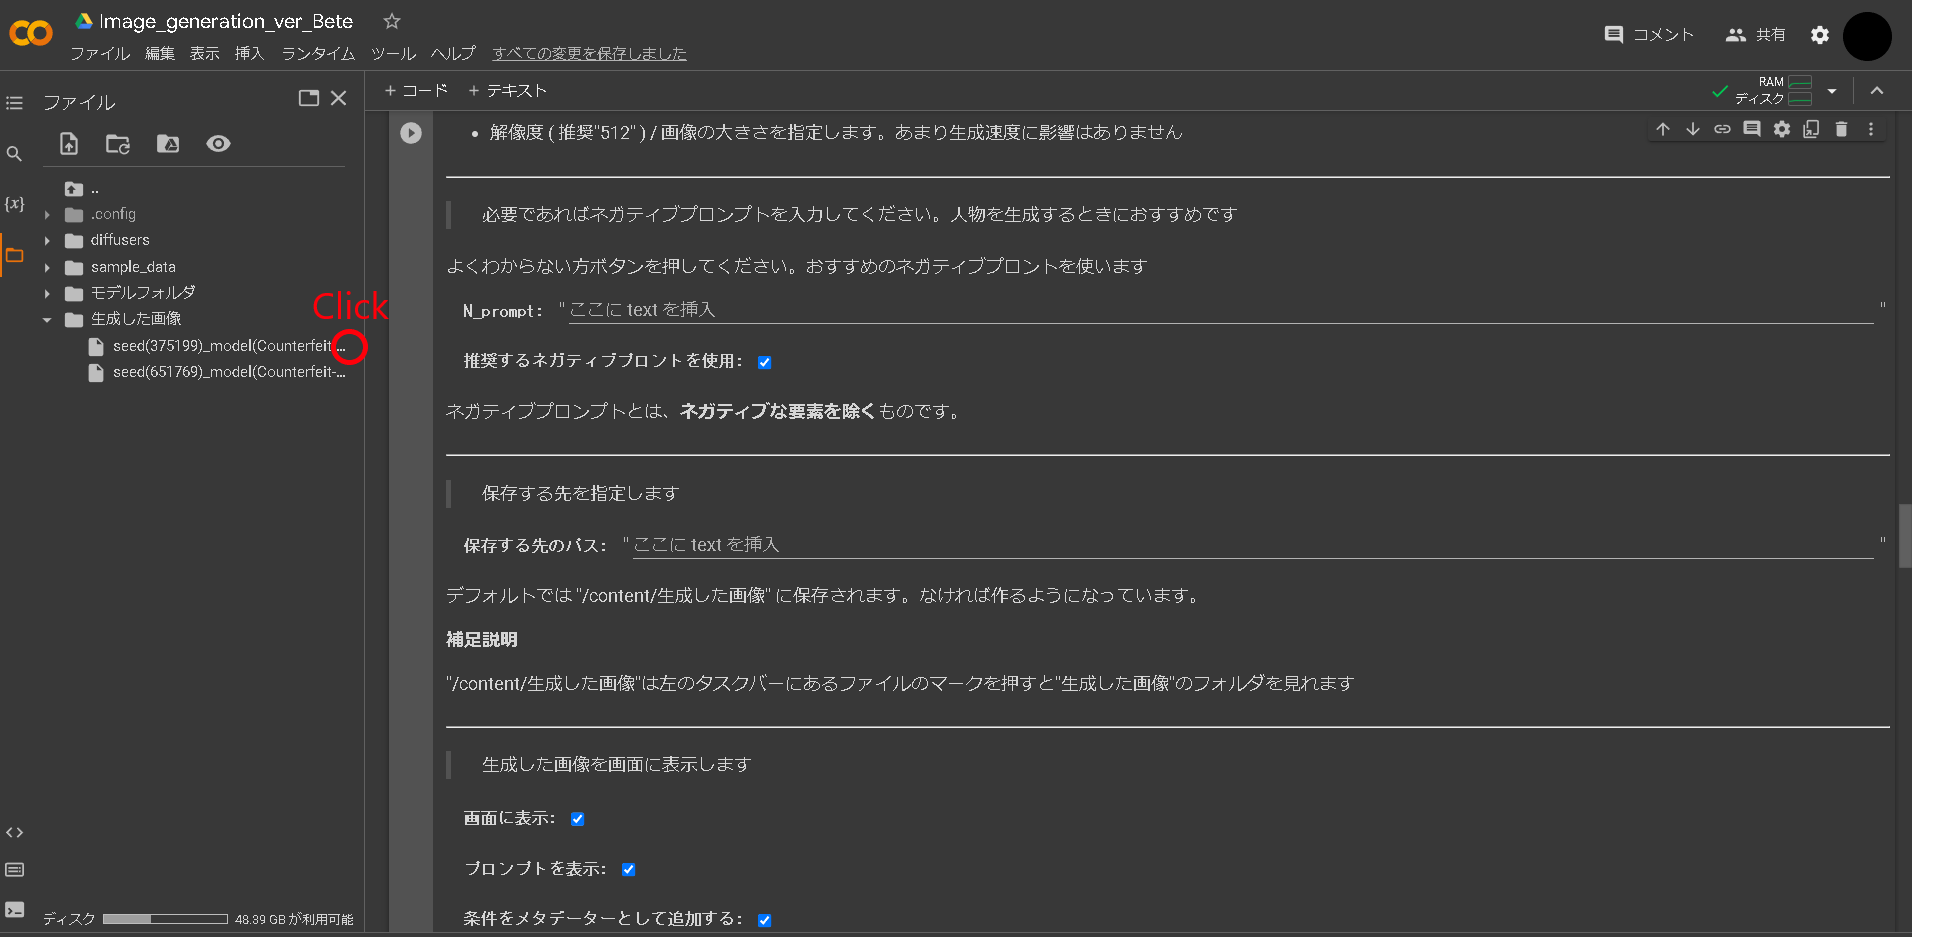

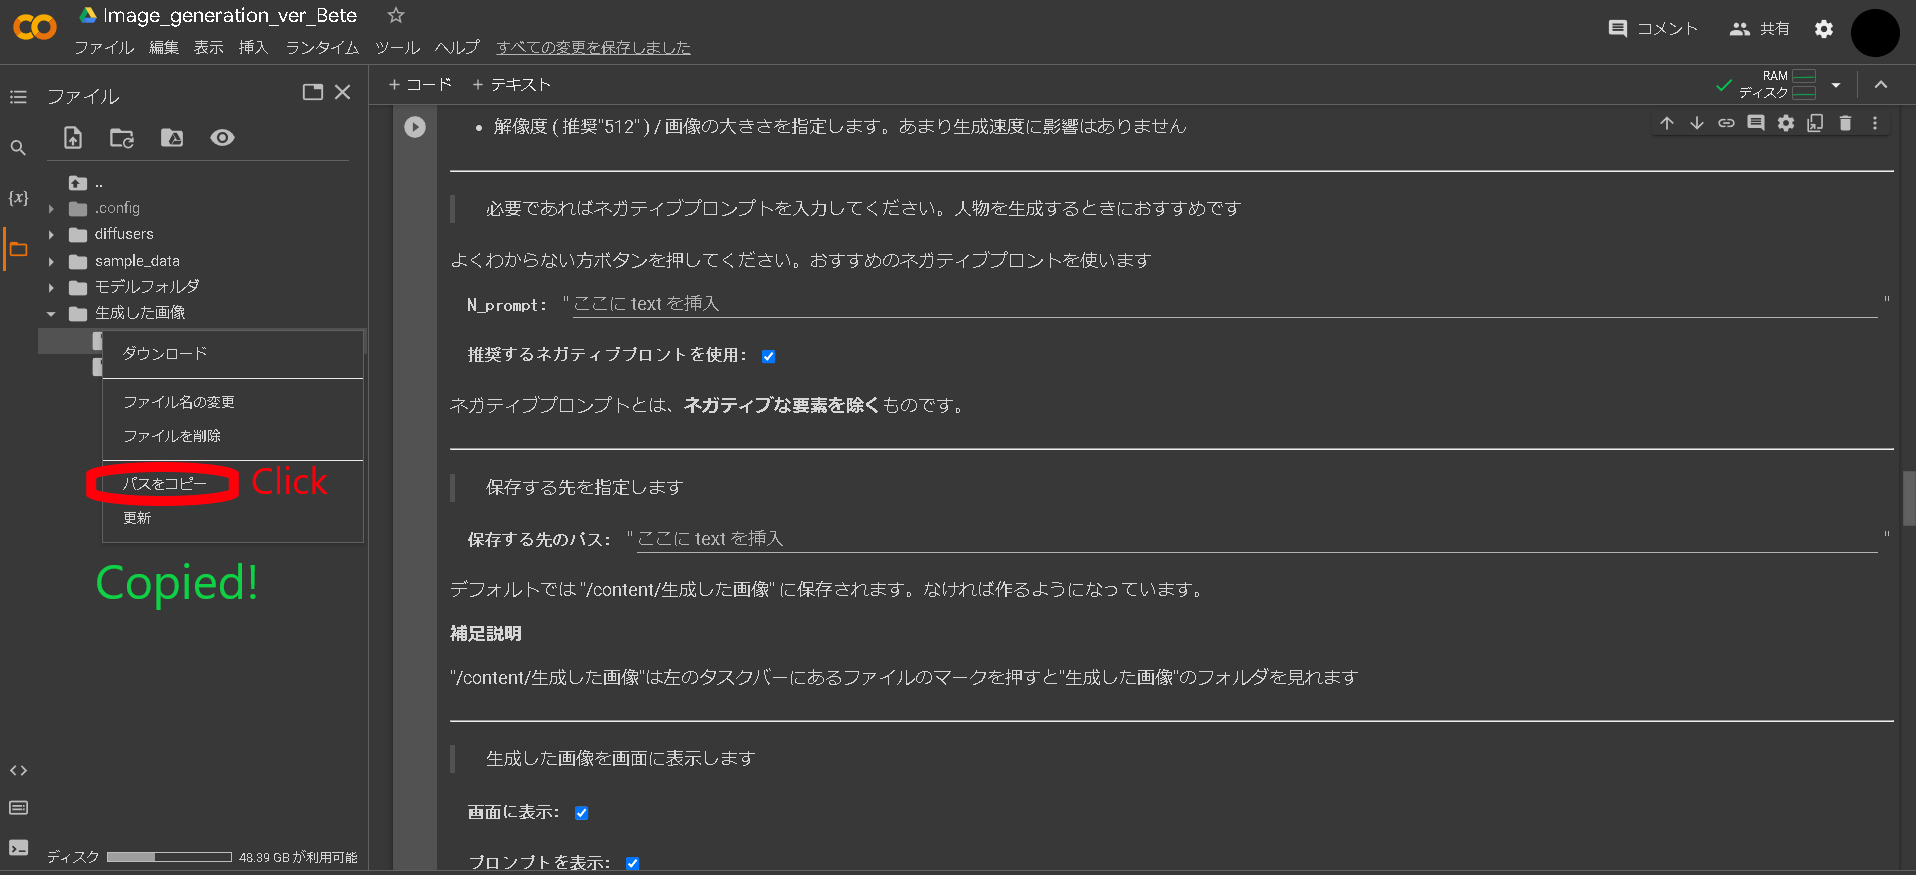

In [ ]:
#@title  #How to copy the path of an image {display-mode: "form"}
from IPython.display import Image, display
#@markdown # Please modify the steps as needed

#@markdown １枚目の画像のみ赤でくくられた部分がセルの実行ボタンを示していました。画像のパスをコピーする場合は青でくくられた部分をクリックしてください

#@markdown (In the first image, the part surrounded by red indicates the cell execution button. To copy the path of the image, please click on the part surrounded by blue.)

images = [
    "/content/手順No.1.PNG",
    "/content/手順No.2.PNG",
    "/content/手順No.3.PNG",
    "/content/手順最終.png"
]

# 画像を横に並べて表示します
for image in images:
    display(Image(image, width=500))

#**Readme**(日本語版)
#利用規約

本画像生成ノーブックを使用するにあたって、利用規約の内容に全て同意したとみなします。

# **重要な注意点**：
* **商用利用はご遠慮ください。**
* **画像生成によって起こった問題について、私は一切責任を負いません。**

>免責事項:
*  使用にあたっては、自己責任でお願いします。
*  本モデルは予告なく変更・非公開・削除する可能性があります。
*  利用規約は予告なく変更する場合があります。
*  このモデルは、趣味で作成したものであり、商用利用などは意図していません。
*  使用にあたって発生した通信量、電気料金など金銭に関わるものの負担は追い兼ねます
*  Stable Diffusion-Ver2.1やその他の追加ライブラリに関する規約がある場合は、それらも確認することを強くお勧めします。
*  本プロジェクトを利用することにより生じた一切の問題について、私は一切責任を負いません。

ー本プロジェクトとは、本画像生成ノートブックや、githubのページなどをさします
___
#本プロジェクトの説明
Stable Diffusion-Ver2.1をベースにした画像生成ノートブックです。


>使用させていただいたライブラリ
- Stable Diffusion-ver2.1
- CLIP
- tqdm
- ftfy
- scipy
- regex
- torch
- diffusers
- accelerate
- safetensors
- transformers

※2023/5/12時点
---

謝辞

本画像生成ノートブックの作成にあたり、オープンソースのリソースやフリーのツールを使用させていただきました。個人的な利用でしたが、これらのリソースやツールがあったからこそ、本プロジェクトを実現することができました。
この場を借りて、オープンソースのコミュニティや、フリーのツールを提供してくださった方々に感謝の意を表します。素晴らしいツールや技術を提供してくださり、本プロジェクトを支援してくださったことに心から感謝いたします。

#**Readme(English_ver)**
# Terms of Use

By using this image generation notebook, you agree to all the contents of the Terms of Use.

Important Notice:
**Please refrain from using for commercial purposes.**
**I am not responsible for any problems caused by image generation.**

>Disclaimer:
* Please use it at your own risk.
* This NoteBook may be changed, unpublished, or deleted without notice.
* The terms of use may be changed without notice.
* This NoteBook is created for personal use and is not intended for commercial use.
* If there are terms and conditions for Stable Diffusion-Ver2.1 and other additional libraries, it is strongly recommended to confirm them as well.
* I am not responsible for any problems caused by using this project.

ー This project refers to the image generation notebook and GitHub pages.

---

# Description of this project

This is an image generation notebook based on Stable Diffusion-Ver2.1.

**Tools used**
* As of 2023/5/12

>**Libraries used**
- Stable Diffusion-ver2.1
- CLIP
- tqdm
- ftfy
- scipy
- regex
- torch
- diffusers
- accelerate
- safetensors
- transformers

---

# Acknowledgements

I used open source resources and free tools to create this image generation notebook. Although it was for personal use, it was only possible to realize this project because of these resources and tools.
I would like to express my gratitude to the open source community and those who provide free tools. I sincerely appreciate your support for this project by providing great tools and technologies.
